# imports

In [1]:
import anndata as ad
import pandas as pd

import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
full = ad.read_h5ad('../data/daniocell2023_gastrulation.cells.h5ad')
full.X = full.X.toarray()

adata_mc = ad.read_h5ad('../data/daniocell2023_gastrulation.metacells.h5ad')
adata_mc.X = adata_mc.X.toarray()

df_cell_to_cluster_scvi = pd.read_csv('../data/cells_cluster_data.csv')

print(f"Full: {full.n_obs} cells, {full.n_vars} genes")
print(f"Full: {adata_mc.n_obs} metacells, {adata_mc.n_vars} genes")

Full: 35705 cells, 28833 genes
Full: 1010 metacells, 28833 genes


# Metacells

In [3]:
dev_time_values = full.obs['hpf'].unique()
def to_nearest_value(x):
    return dev_time_values[np.argmin(np.abs(dev_time_values - x))]
adata_mc.obs['developmental_time_y'] = adata_mc.obs['hpf'].apply(to_nearest_value)

In [4]:
adata_mc.obs.head(5)

,grouped,total_umis,__zeros_downsample_umis,metacells_rare_gene_module,rare_metacell,u,v,w,x,y,hpf,cell_type,developmental_time_y
M0.75,49,306329,3244,-1,False,4.653786,1.381917,2.338467,6.311879,10.662604,7.230612,Paraxial mesoderm,7.0
M1.61,25,153311,2518,-1,False,4.981555,-0.222032,2.946222,5.380586,12.226099,7.000000,Epidermis,7.0
M2.97,26,157097,2638,-1,False,2.785228,0.120685,1.139949,8.310302,12.323635,7.615385,Epidermis,8.0
M3.24,39,232855,3055,-1,False,3.858558,3.014118,2.090688,7.346654,9.336953,7.879487,Endoderm,8.0
M4.24,47,220201,2183,-1,False,-1.641914,3.120902,-0.659841,12.384980,10.736706,9.042553,Epidermis,9.0


## umi counts per metacell

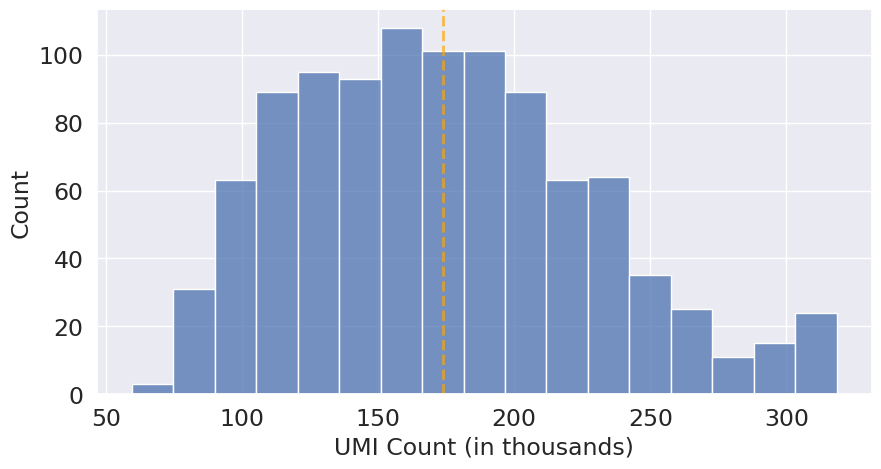

In [5]:
sb.set_theme()

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=(adata_mc.obs["total_umis"]/1000))

plt.axvline(x=np.mean(adata_mc.obs['total_umis'])/1000, color='orange', linestyle='dashed', linewidth=2, alpha=.7)

# annotations
plt.xticks(fontsize=17)
plt.xlabel("UMI Count (in thousands)", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/metacells/umi_metacells_hist.png', dpi=300, bbox_inches="tight")
plt.show()

In [6]:
print(np.mean(adata_mc.obs['total_umis']))
print(np.std(adata_mc.obs['total_umis']))
print(np.min(adata_mc.obs['total_umis']))
print(np.max(adata_mc.obs['total_umis']))

173974.04257425742
54138.19214524635
59540
318436


## cells per metacell

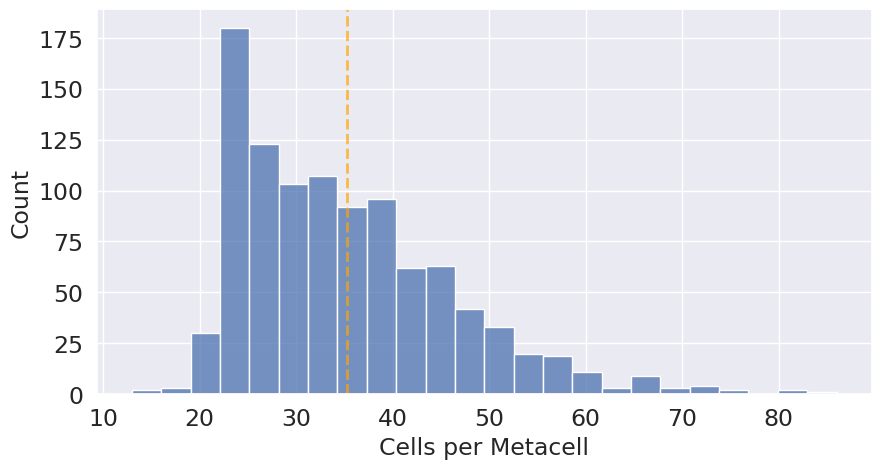

In [7]:
sb.set_theme()

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=(adata_mc.obs["grouped"]))

plt.axvline(x=np.mean(adata_mc.obs['grouped']), color='orange', linestyle='dashed', linewidth=2, alpha=.7)

# annotations
plt.xticks(fontsize=17)
plt.xlabel("Cells per Metacell", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/metacells/cells_in_metacells_hist.png', dpi=300, bbox_inches="tight")
plt.show()

In [8]:
print(np.mean(adata_mc.obs['grouped']))
print(np.std(adata_mc.obs['grouped']))
print(np.min(adata_mc.obs['grouped']))
print(np.max(adata_mc.obs['grouped']))

35.32871287128713
10.839187582665527
13
86


## metacells per dev time

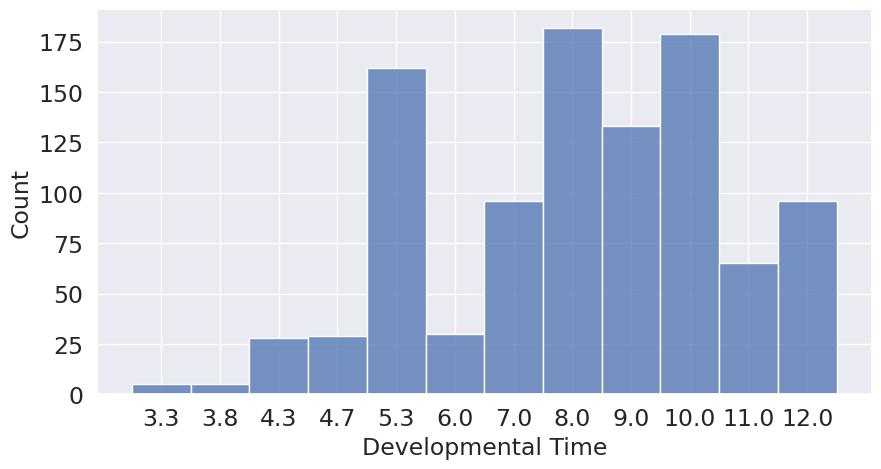

In [9]:
sb.set_theme()

unique_times = np.sort(adata_mc.obs["developmental_time_y"].unique())
bar_positions = np.arange(len(unique_times))

# value mapping
time_mapping = dict(zip(unique_times, bar_positions))

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=adata_mc.obs["developmental_time_y"].map(time_mapping), 
         bins=12,
         discrete=True)

# annotations
plt.xticks(bar_positions, unique_times, fontsize=17)
plt.xlabel("Developmental Time", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/metacells/dev_time_metacells_hist.png', dpi=300, bbox_inches="tight")
plt.show()

## UMAP

In [10]:
import umap

umap_model = umap.UMAP(n_neighbors=4, min_dist=.1, n_components=2, random_state=42)
umap_data = umap_model.fit_transform(adata_mc.X[:,adata_mc.var['selected_gene']])

umap_df = pd.DataFrame(umap_data, index=adata_mc.obs_names)
umap_df['cell_type'] = adata_mc.obs['cell_type']

/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


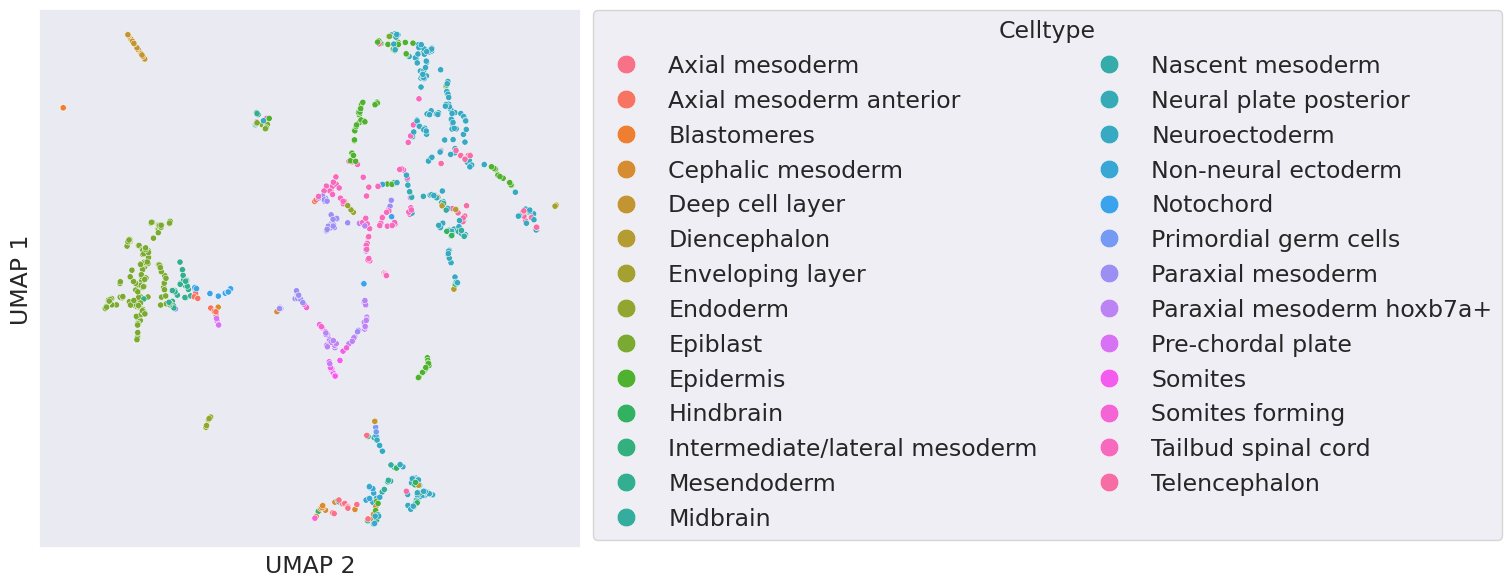

In [11]:
sb.set_theme()

plt.figure(figsize=(7, 7))

ax = sb.scatterplot(x=umap_df[0], y=umap_df[1], s=20, hue=umap_df['cell_type'], legend=True)

# annotations
plt.xticks([],fontsize=17)
plt.xlabel("UMAP 2", fontsize=17)
plt.ylabel("UMAP 1", fontsize=17)
plt.yticks([],fontsize=17)

# modify legend
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.02), fontsize=17, ncol=2, markerscale=3)
ax.get_legend().set_title("Celltype", prop={'size': 17})

plt.savefig('../figures/metacells/mc_umap.png',dpi=300, bbox_inches='tight')
plt.show()

# scVI clustering

In [12]:
tmp = pd.DataFrame(full.X.transpose(), index=full.var_names.to_list(), columns=df_cell_to_cluster_scvi['predicted_cluster'])
tmp_cell_names = pd.DataFrame(full.X.transpose(), index=full.var_names.to_list(), columns=df_cell_to_cluster_scvi['cell'])
eg_m2 = tmp.groupby(tmp.columns,axis=1).sum()

/tmp/ipykernel_3024561/1136710349.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  eg_m2 = tmp.groupby(tmp.columns,axis=1).sum()


In [13]:
adata_scVI = ad.AnnData(eg_m2.transpose().to_numpy())
adata_scVI.obs_names = list(eg_m2.columns.astype(str).to_list())
adata_scVI.var_names = list(eg_m2.index)
adata_scVI.var = full.var
adata_scVI.obs['grouped'] = [tmp[i].size / len(tmp.index) for i in range(len(eg_m2.columns))]
adata_scVI.obs['total_umis'] = eg_m2.sum(axis=0).to_list()

full.obs['scVI_cluster'] = df_cell_to_cluster_scvi['predicted_cluster'].to_list()

adata_scVI.obs['majority_developmental_time'] = [full.obs[full.obs['scVI_cluster'] == i]['hpf'].mode()[0] for i in range(len(eg_m2.columns))]

adata_scVI.obs['majority_cell_type'] = [full.obs[full.obs['scVI_cluster'] == i]['cell_type'].mode()[0] for i in range(len(eg_m2.columns))]
    
adata_scVI.layers['normalized_to_1'] = adata_scVI.X / adata_scVI.X.sum(axis=1, keepdims=True)
adata_scVI.layers['normalized_log1p'] = np.log1p(adata_scVI.X)

In [14]:
adata_scVI.obs.head(2)

,grouped,total_umis,majority_developmental_time,majority_cell_type
0,51.0,327302.0,5.3,Epiblast
1,54.0,307627.0,5.3,Epiblast


## umi counts per scVI cluster

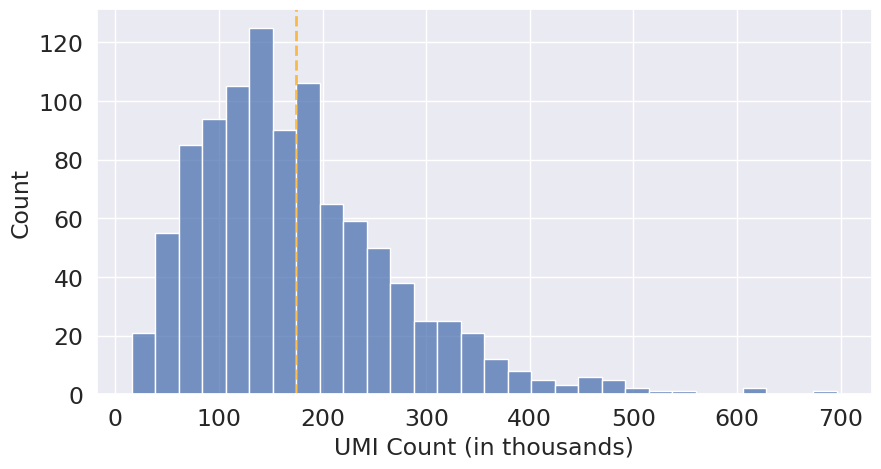

In [15]:
sb.set_theme()

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=(adata_scVI.obs["total_umis"]/1000))

plt.axvline(x=np.mean(adata_scVI.obs['total_umis'])/1000, color='orange', linestyle='dashed', linewidth=2, alpha=.7)

# annotations
plt.xticks(fontsize=17)
plt.xlabel("UMI Count (in thousands)", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/scvi/umi_scVI_hist.png', dpi=300)
plt.show()

In [16]:
print(np.mean(adata_scVI.obs['total_umis']))
print(np.std(adata_scVI.obs['total_umis']))
print(np.min(adata_scVI.obs['total_umis']))
print(np.max(adata_scVI.obs['total_umis']))

174085.2504950495
94949.59066326932
15908.0
696013.0


## cells per scVI cluster

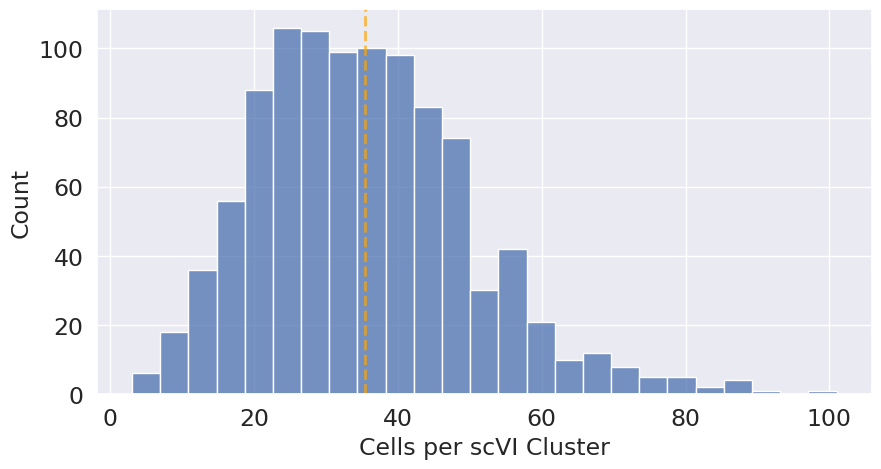

In [17]:
sb.set_theme()

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=(adata_scVI.obs["grouped"]))

plt.axvline(x=np.mean(adata_scVI.obs['grouped']), color='orange', linestyle='dashed', linewidth=2, alpha=.7)

# annotations
plt.xticks(fontsize=17)
plt.xlabel("Cells per scVI Cluster", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/scvi/cells_in_scVICluster_hist.png', dpi=300)
plt.show()

In [18]:
print(np.mean(adata_scVI.obs['grouped']))
print(np.std(adata_scVI.obs['grouped']))
print(np.min(adata_scVI.obs['grouped']))
print(np.max(adata_scVI.obs['grouped']))

35.351485148514854
14.94200745894757
3.0
101.0


## scVI cluster per dev time

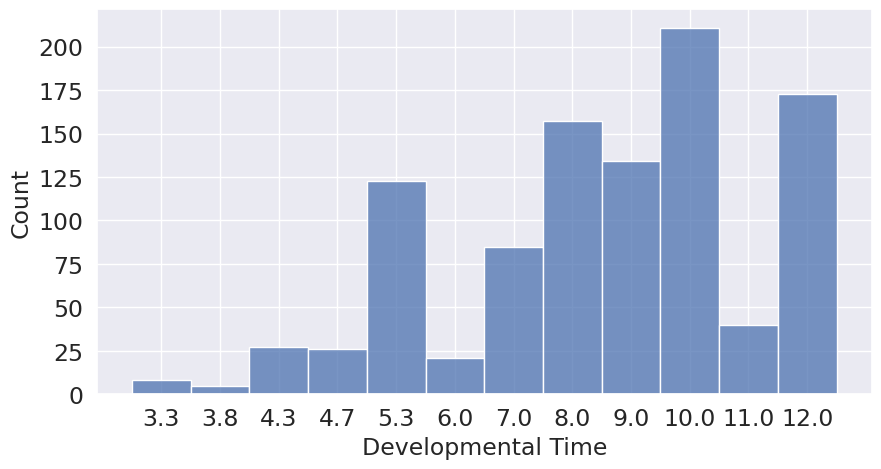

In [19]:
sb.set_theme()

unique_times = np.sort(adata_scVI.obs["majority_developmental_time"].unique())
bar_positions = np.arange(len(unique_times))

# value mapping
time_mapping = dict(zip(unique_times, bar_positions))

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=adata_scVI.obs["majority_developmental_time"].map(time_mapping), 
         bins=12,
         discrete=True)

# annotations
plt.xticks(bar_positions, unique_times, fontsize=17)
plt.xlabel("Developmental Time", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)


plt.savefig('../figures/scvi/dev_time_scVICluster_hist.png', dpi=300, bbox_inches="tight")
plt.show()

## UMAP

In [20]:
import umap

umap_model = umap.UMAP(n_neighbors=5, min_dist=.05, random_state=40)
umap_data = umap_model.fit_transform(adata_scVI.layers['normalized_to_1'][:,adata_scVI.var['selected_gene']])

umap_df = pd.DataFrame(umap_data, index=adata_scVI.obs_names)
umap_df['cell_type'] = adata_scVI.obs['majority_cell_type']
umap_df.sort_values('cell_type', inplace=True)

/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


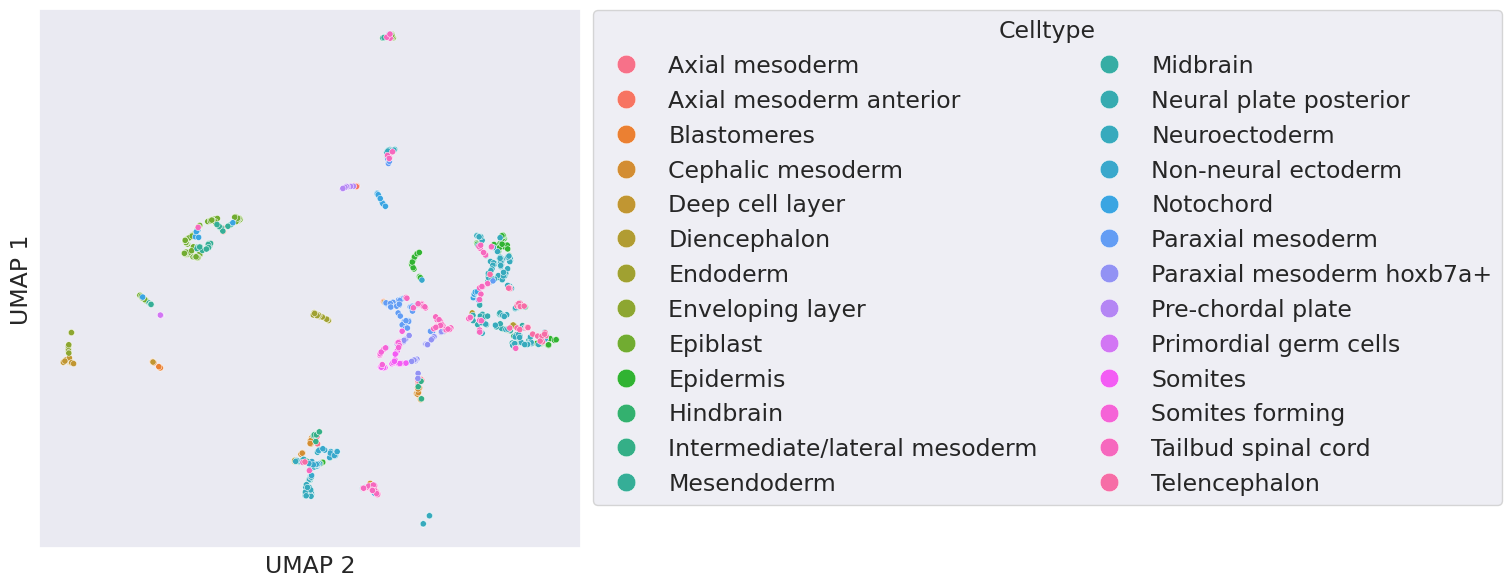

In [21]:
sb.set_theme()

plt.figure(figsize=(7, 7))

ax = sb.scatterplot(x=umap_df[0], y=umap_df[1], s=20, hue=umap_df['cell_type'], legend=True)

# annotations
plt.xticks([],fontsize=17)
plt.xlabel("UMAP 2", fontsize=17)
plt.ylabel("UMAP 1", fontsize=17)
plt.yticks([],fontsize=17)

# customize legend
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.02), fontsize=17, ncol=2, markerscale=3)
ax.get_legend().set_title("Celltype", prop={'size': 17})

plt.savefig('../figures/scvi/scVI_umap.png',dpi=300, bbox_inches='tight')
plt.show()

# scRNA 

## cell type proportion per dev time

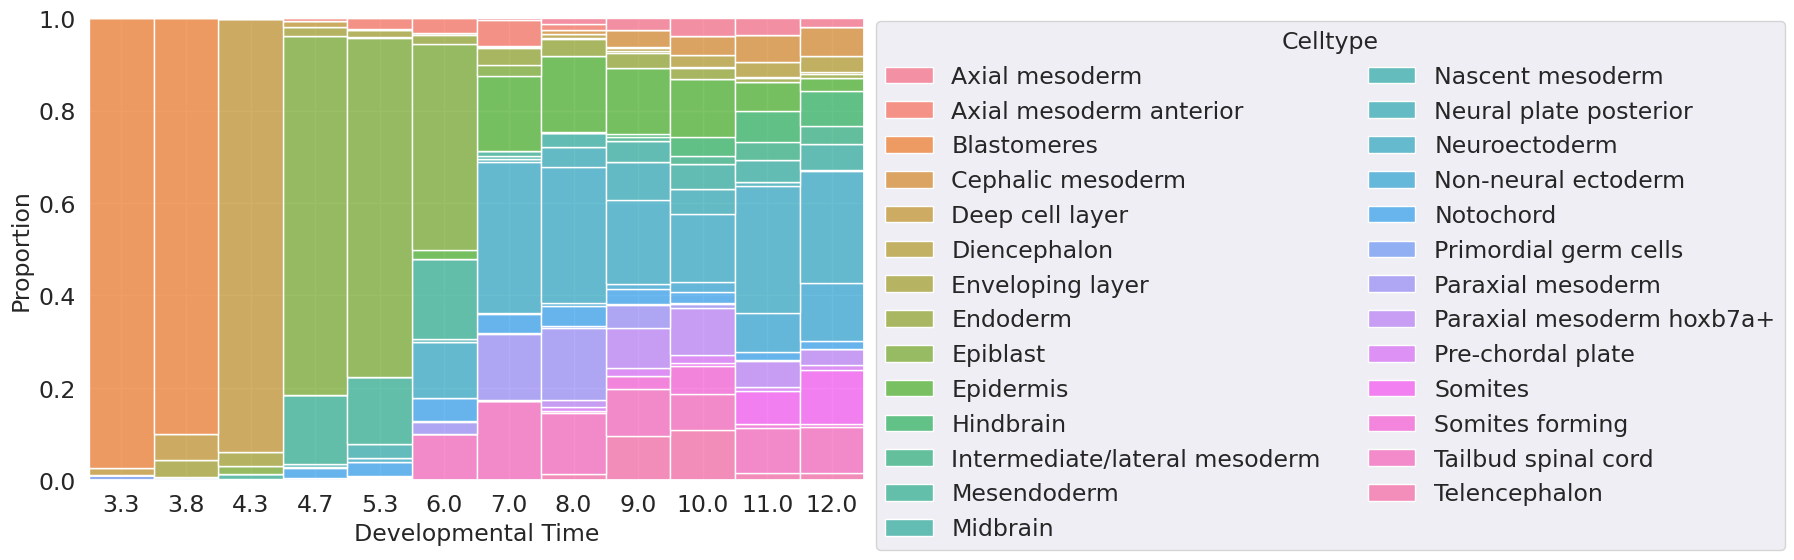

In [22]:
df = full.obs

sb.set_theme()

unique_times = np.sort(df["hpf"].unique())
bar_positions = np.arange(len(unique_times))  

# mapping
time_mapping = dict(zip(unique_times, bar_positions))

plt.figure(figsize=(10, 6))
ax = sb.histplot(
    data=df,
    x=full.obs["hpf"].map(time_mapping), 
    hue="cell_type",
    multiple="fill",
    stat="percent",
    discrete=True,
    shrink=1)

plt.xticks(bar_positions, unique_times, fontsize=17)
plt.xlabel("Developmental Time", fontsize=17)
plt.ylabel("Proportion", fontsize=17)
plt.yticks(fontsize=17)

# legend configuration
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.02), fontsize=17, ncol=2)
ax.get_legend().set_title("Celltype", prop={'size': 17})

plt.savefig('../figures/scRNA-seq/dataset_celltype_proportion.png', dpi=300, bbox_inches="tight")
plt.show()

## cells per dev time

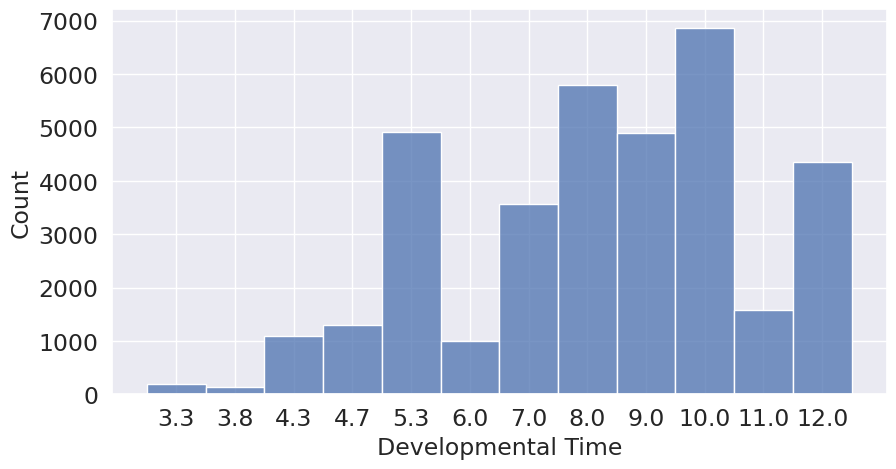

In [23]:
sb.set_theme()

unique_times = np.sort(df["hpf"].unique())
bar_positions = np.arange(len(unique_times))

# mapping
time_mapping = dict(zip(unique_times, bar_positions))

plt.figure(figsize=(10, 5))

ax = sb.histplot(x=full.obs["hpf"].map(time_mapping), 
         bins=12,
         discrete=True)

# annotations
plt.xticks(bar_positions, unique_times, fontsize=17)
plt.xlabel("Developmental Time", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/scRNA-seq/zebra_cellcounts_stages.png', dpi=300, bbox_inches="tight")
plt.show()

## UMAP dev time

In [24]:
full_norm = full.copy()
sc.pp.normalize_total(full_norm, target_sum=1e4)
sc.pp.log1p(full_norm)
sc.pp.pca(full_norm)
sc.pp.neighbors(full_norm)
sc.tl.umap(full_norm)

<Figure size 1400x800 with 0 Axes>

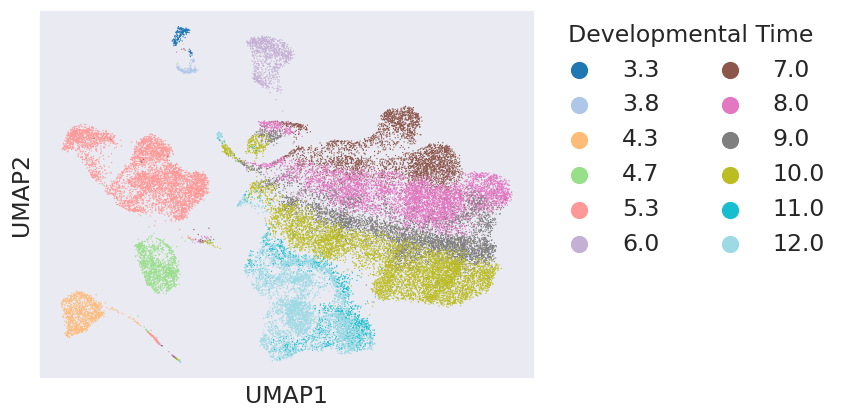

In [25]:
plt.figure(figsize=(14,8))

full_norm.obs['hpf'] = full_norm.obs['hpf'].astype('category')

ax = sc.pl.umap(full_norm, color=['hpf'], palette="tab20", legend_fontsize=17, show=False)
                
plt.xlabel("UMAP1", fontsize=17)
plt.ylabel("UMAP2", fontsize=17)

sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.02), fontsize=17, ncol=2, markerscale=1.9)
ax.get_legend().set_title("Developmental Time", prop={'size': 17})

plt.title('')

plt.savefig('../figures/scRNA-seq/scRNA_full_dev_time_umap', dpi=300, bbox_inches="tight")
plt.show()